# Treinamento e Salvamento do Modelo Gradient Boosting

In [1]:
import pandas as pd
import re
import string
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import re
import string
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


# Importações necessárias
import pandas as pd
import re
import string
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

# Configuração de estilo para gráficos (CORREÇÃO: Usar 'seaborn-v0_8' ou 'ggplot')
plt.style.use('seaborn-v0_8')  # Alternativa: 'ggplot', 'fivethirtyeight'
sns.set_theme(style="whitegrid")  # Configuração moderna do Seaborn
%matplotlib inline

Pré-processamento dos Dados

In [2]:
# Função de pré-processamento
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Carregar dados
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake["class"] = 0
df_true["class"] = 1
df = pd.concat([df_fake, df_true])
df = df.drop(columns=["title", "subject", "date"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df["text"] = df["text"].apply(preprocess_text)

# Verificar balanceamento das classes
print("Distribuição de classes (0 = Fake, 1 = Real):")
print(df['class'].value_counts(normalize=True))

# Verificar diversidade do vocabulário por notícia
print("Diversidade de vocabulário por notícia (número de palavras únicas):")
print(df["text"].apply(lambda x: len(set(x.split()))).describe())


# Dividir dados
X = df["text"]
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vetorização
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# Modelo com controle de complexidade para evitar overfitting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
print("Treinando o modelo...")
gb_model.fit(X_train_vec, y_train)

# Salvar os arquivos .pkl
joblib.dump(gb_model, "modelo_treinado.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump((X_test_vec, y_test), "test_data.pkl")
print("Modelo e vetorizador salvos!")

Distribuição de classes (0 = Fake, 1 = Real):
class
0    0.522985
1    0.477015
Name: proportion, dtype: float64
Diversidade de vocabulário por notícia (número de palavras únicas):
count    44898.000000
mean       208.756849
std        133.015972
min          0.000000
25%        126.000000
50%        201.000000
75%        264.000000
max       2407.000000
Name: text, dtype: float64
Treinando o modelo...
Modelo e vetorizador salvos!


Avaliação do Modelo

Relatório de Classificação


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5863
           1       0.99      1.00      0.99      5362

    accuracy                           1.00     11225
   macro avg       0.99      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

Acurácia: 1.00

Relatório de Classificação:
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5863
        Real       0.99      1.00      0.99      5362

    accuracy                           1.00     11225
   macro avg       0.99      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



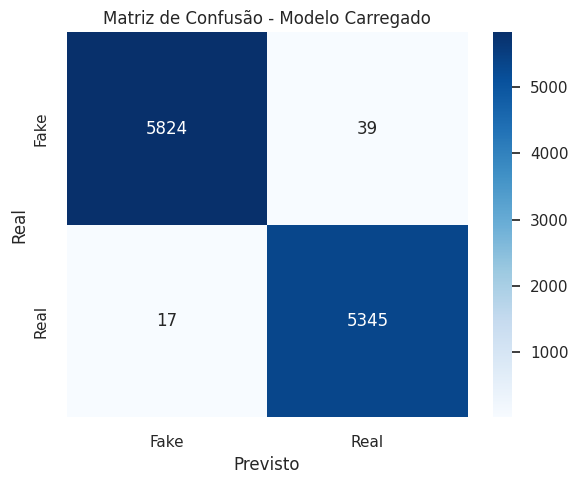

In [7]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Carregar modelo, vetorizador e dados de teste
gb_model = joblib.load("modelo_treinado.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")
X_test_vec, y_test = joblib.load("test_data.pkl")


# Previsão
#y_pred = gb_model.predict(X_test_vec)
y_pred = gb_model.predict(X_test_vec)
y_pred_proba = gb_model.predict_proba(X_test_vec)[:, 1]

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


# Avaliação
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Acurácia: {acc:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

# Matriz de confusão
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo Carregado")
plt.tight_layout()
plt.show()

Validação Cruzada (5-fold)

In [5]:
#MODELO 1.0
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gb_model, X_train_vec, y_train, cv=cv, scoring='accuracy')
print("\nAcurácia média na validação cruzada:", np.mean(cv_scores))
print("Desvio padrão:", np.std(cv_scores))


Acurácia média na validação cruzada: 0.9953969010984602
Desvio padrão: 0.0005712480197394466


5.4. Curva ROC

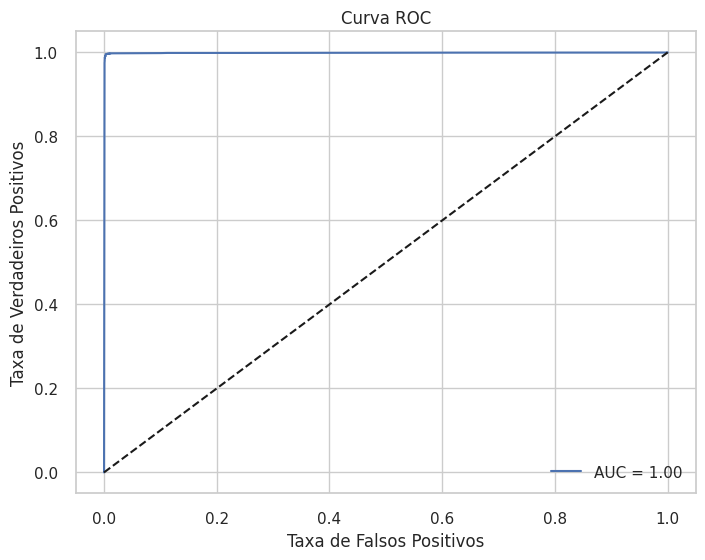

In [8]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Curvas de Aprendizado e Desempenho

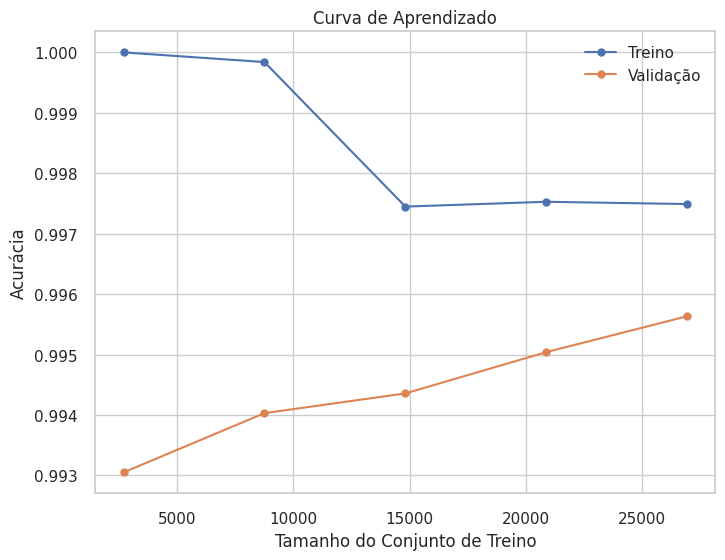

In [9]:
train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X_train_vec, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy'
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Treino')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validação')
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Acurácia')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

Acompanhamento da Acurácia durante o Treinamento

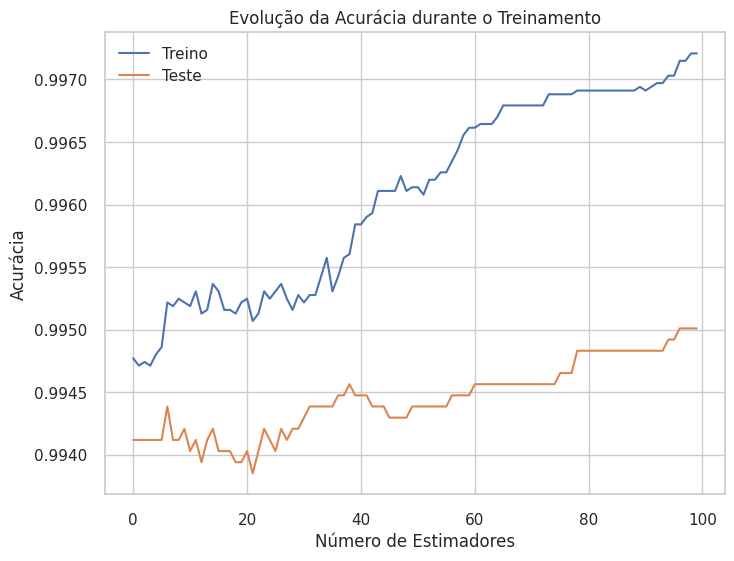

In [11]:
train_acc = []
test_acc = []
for i, pred in enumerate(gb_model.staged_predict(X_train_vec)):
    train_acc.append(accuracy_score(y_train, pred))
for i, pred in enumerate(gb_model.staged_predict(X_test_vec)):
    test_acc.append(accuracy_score(y_test, pred))

plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Treino')
plt.plot(test_acc, label='Teste')
plt.xlabel('Número de Estimadores')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.legend()
plt.show()

 Salvamento do Histórico

In [12]:
history = {
    'train_accuracy': train_acc,
    'test_accuracy': test_acc,
    'cv_scores': cv_scores.tolist(),
    'classification_report': classification_report(y_test, y_pred, output_dict=True),
    'roc_auc': auc_score,
    'confusion_matrix': cm.tolist()
}

joblib.dump(history, 'training_history.pkl')
print("Histórico salvo com sucesso!")

Histórico salvo com sucesso!
